<a href="https://colab.research.google.com/github/taravatp/Panopic-Feature-Pyramid-Network/blob/main/DataLoaders/coco_panoptic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU torch_snippets
!pip install import_ipynb 
!pip install jsonlines

In [ ]:
cd /content/drive/MyDrive/panoptic_FPN

/content/drive/MyDrive/panoptic_FPN


In [ ]:
import torch

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torch_snippets import *

from pycocotools.coco import COCO
from pycocotools import mask

import import_ipynb
import utils

In [ ]:
class panoptic_dataset(Dataset):
      
  def __init__(self,flag):

    json_stuff = '/content/drive/MyDrive/panoptic_FPN/dataset/annotations/stuff_val2017.json'
    json_things = '/content/drive/MyDrive/panoptic_FPN/dataset/annotations/instances_val2017.json'
    self.root = '/content/drive/MyDrive/panoptic_FPN/dataset/val2017'

    self.cocoStuff = COCO(json_stuff)
    self.cocoThing = COCO(json_things)
    self.image_IDS = self.get_imageIDS()

    if flag == 'train':
      self.image_IDS = self.image_IDS[0:1500] #using only the first 1500 images for training
      self.images = self.cocoStuff.loadImgs(self.image_IDS) #loading images by their IDs -its a list of dictionaries 
    else: 
      self.image_IDS = self.image_IDS[1500:1700] #using only 200 images for testing
      self.images = self.cocoStuff.loadImgs(self.image_IDS) #loading images by their IDs - its a list of dictionaries 

    self.category_IDS_things = self.cocoThing.getCatIds() #getting the ID of all the available categories
    self.categories_things = self.cocoThing.loadCats(self.category_IDS_things) #loading categories by their IDs - each category is a dictionary   

  def get_imageIDS(self):
    image_IDS_stuff = self.cocoStuff.getImgIds() #getting the ID of all images
    image_IDS_stuff = [item for item in image_IDS_stuff if len(self.cocoStuff.getAnnIds(item))!=0] #removing images which do not have any stuff annotations

    image_IDS_things = self.cocoThing.getImgIds() #getting the ID of all images
    image_IDS_things = [item for item in image_IDS_things if len(self.cocoThing.getAnnIds(item))!=0] #removing images which do not have any things annotations

    image_IDS_stuff = set(image_IDS_stuff) #converting list to set
    image_IDS_things = set(image_IDS_things) #converting list to set

    image_IDS = list(image_IDS_stuff.intersection(image_IDS_things)) #finding the intersection
    return image_IDS
  
  # def get_className(self,classID):
  #   for i in range(len(self.categories_things)):
  #     if self.categories_things[i]['id'] == classID:
  #       return self.categories_things[i]['name'],i+1
  #   return None


  def get_stuff_segmentation_target_mask(self,annotations):
    segmentation_mask = np.zeros((640,480))
    labels = []
    areas = []
    masks = []
    for i in range(len(annotations)):
      label = annotations[i]['category_id'] - 92 #rescaling - min value will be 0 - and max value will be 91
      label = torch.as_tensor(label,dtype=torch.int64)
      labels.append(label) #storing the labels of all the segments in an image

      area = annotations[i]['category_id'] 
      area = torch.as_tensor(area, dtype=torch.float32)
      areas.append(area) #storing the areas of all the segments in an image

      _mask = mask.decode(annotations[i]['segmentation']) #this mask will have 0 and 1 values
      _mask = np.where(_mask==1,label,_mask) #each pixel will have its class label
      _mask = cv2.resize(_mask, dsize=(480,640), interpolation=cv2.INTER_NEAREST) #masks will be resized
      segmentation_mask = np.maximum(segmentation_mask,_mask)   

    segmentation_mask = np.where(segmentation_mask==0,91,segmentation_mask) #fill the zero values with 91 wich refers to the 'other' class
    segmentation_mask = torch.as_tensor(segmentation_mask,dtype=torch.int64) 
    return segmentation_mask

  def get_things_segmentation_target_mask(self,image,annotations):

    imageID = image['id']
    bbox=[]
    areas=[]
    labels=[]
    masks=[]

    for i in range(len(annotations)):
      boxes = annotations[i]['bbox']
      bbox.append([boxes[0],boxes[1],boxes[0]+boxes[2],boxes[1]+boxes[3]])
      areas.append(annotations[i]['area'])
      labels.append(annotations[i]['category_id'])
      masks.append(self.cocoThing.annToMask(annotations[i])) #its a binary mask  
   
    bbox = torch.as_tensor(np.array(bbox), dtype=torch.float32)
    areas = torch.as_tensor(np.array(areas), dtype=torch.float32)
    labels = torch.as_tensor(np.array(labels),dtype=torch.int64)
    masks = torch.as_tensor(np.array(masks),dtype=torch.uint8)
    imageID = torch.tensor(np.array([imageID]))
    
    target = {}
    target['boxes'] = bbox
    target['labels'] = labels
    target['masks'] = masks
    target['image_id'] = imageID
    target['area'] = areas
    
    return target

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):

    image = self.images[idx]

    image_path = os.path.join(self.root,image['file_name'])
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR) #all images are in BGR format
    original_image = cv2.resize(original_image, dsize=(480,640), interpolation=cv2.INTER_NEAREST)
    original_image = original_image.transpose(2,0,1) #(H-W-C)
    original_image = original_image/255 #normalizing
    original_image = torch.as_tensor(original_image, dtype=torch.float) #converting numpy to tensor

    imageID = image['id'] #getting the id of that image

    annotation_IDS_stuff = self.cocoStuff.getAnnIds(imgIds=imageID) #getting the annotation ID of an image
    annotations_stuff = self.cocoStuff.loadAnns(annotation_IDS_stuff) #loading the annotations

    annotation_IDS_instance =  self.cocoThing.getAnnIds(imgIds=imageID)
    annotations_instance = self.cocoThing.loadAnns(annotation_IDS_instance) #loading the annotations
    
    target_stuff = self.get_stuff_segmentation_target_mask(annotations_stuff)
    target_things = self.get_things_segmentation_target_mask(image,annotations_instance)

    return original_image,target_stuff,target_things

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!
loading annotations into memory...
Done (t=1.26s)
creating index...
index created!


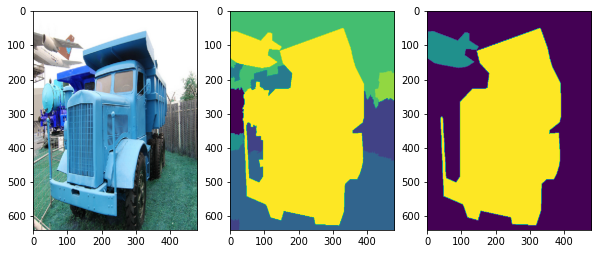

In [ ]:
if __name__ == "__main__":
  sample = panoptic_dataset(flag='test')
  original_image,target_stuff,target_things = sample[30]

  plt.figure(figsize=(10,20))
  plt.subplot(1,3,1)
  plt.imshow(original_image.numpy().transpose(1,2,0))

  plt.subplot(1,3,2)
  plt.imshow(target_stuff)

  masks = target_things['masks']
  things_target = np.zeros((masks.shape[1],masks.shape[2]))    
  for i in range(masks.shape[0]): #iterating over number of masks
    things_target = things_target + (i+1)*masks[i].numpy()
  things_target = cv2.resize(things_target, dsize=(480,640), interpolation=cv2.INTER_NEAREST)
  plt.subplot(1,3,3)
  plt.imshow(things_target)